# Installation

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install
# install()
# !pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main
# import pyreadr

In [2]:
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from scvi.model import CondSCVI, DestVI


dataset = 'seqFISH+'
sc_file_name = 'scRNA.h5ad'
st_file_name = 'ST_10000.h5ad'

sc_file = os.path.join('/Dataset/ST',dataset,sc_file_name)
st_file = os.path.join('/Dataset/ST',dataset,st_file_name)

Global seed set to 0


In [3]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [5]:
sc_adata = sc.read(sc_file)

In [10]:
sc_adata.obs['cell_types']

0          iNeuron
1          iNeuron
2          iNeuron
3          iNeuron
4          iNeuron
           ...    
1686    endo_mural
1687    endo_mural
1688    endo_mural
1689    endo_mural
1690    endo_mural
Name: cell_types, Length: 1691, dtype: category
Categories (6, object): ['Olig', 'astrocytes', 'eNeuron', 'endo_mural', 'iNeuron', 'microglia']

In [14]:
st_adata = sc.read(st_file)

In [17]:
# !pip install scikit-misc --force

In [24]:
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

In [25]:
sc_adata.var

,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
0,474.0,True,1916.0,0.280308,0.909547,1.550934
6,222.0,True,480.0,0.131283,0.645476,2.532912
7,2354.0,True,70.0,1.392076,31.604174,5.662389
8,626.0,True,924.0,0.370195,1.690093,2.003223
12,265.0,True,1718.0,0.156712,0.497912,1.615450
...,...,...,...,...,...,...
19748,361.0,True,1937.0,0.213483,0.660315,1.544229
19801,17.0,True,1712.0,0.010053,0.047828,1.617855
19842,17.0,True,1683.0,0.010053,0.026526,1.628698
19876,149.0,True,1261.0,0.088114,0.307616,1.805015


In [26]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm['spatial'] = st_adata.obsm['location']

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [27]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

In [28]:
intersect

array(['0', '1003', '101', ..., '993', '996', '997'], dtype=object)

In [29]:
# sc.pl.embedding(st_adata, basis="spatial", color="cell_type", s=80)

In [30]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="cell_types")

# Train SC Model

In [31]:
sc_model = CondSCVI(sc_adata, weight_obs=True)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'cell_types', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 1691  │
│      n_vars      │ 1870  │
│     n_labels     │   6   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_types'] │    Olig    │          0          │
│                         │ astrocytes │          1          │
│                         │  eNeuron   │          2          │
│                         │ endo_mural │          3          │
│                         │  iNeuron   │          4          │
│                         │ microglia  │          5          │
└─────────────────────────┴────────────┴─────────────────────┘

In [33]:
sc_adata

AnnData object with n_obs × n_vars = 1691 × 1870
    obs: 'index', 'cell_types', '_scvi_labels'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

In [34]:
sc_model.train(max_epochs=300,use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 300/300: 100%|█| 300/300 [00:38<00:00,  7.71it/s, loss=1.05e+04, v_num=1]


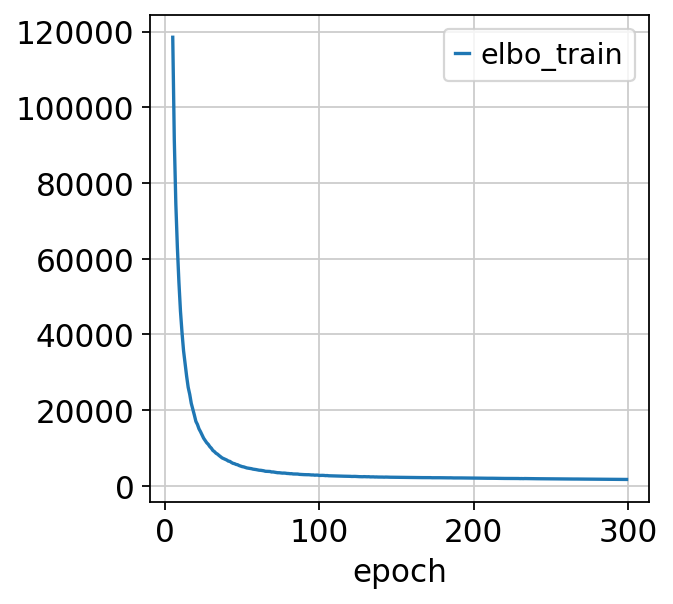

In [35]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

# Train ST Model

In [36]:
DestVI.setup_anndata(st_adata, layer="counts")

In [37]:
sc_adata.var

,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
0,474.0,True,1916.0,0.280308,0.909547,1.550934
1003,1432.0,True,1383.0,0.846836,4.400787,1.744205
101,1133.0,True,700.0,0.670018,4.018858,2.204633
1010,26.0,True,1325.0,0.015376,0.057752,1.774154
1012,1091.0,True,862.0,0.645180,3.555685,2.052923
...,...,...,...,...,...,...
984,756.0,True,288.0,0.447073,3.381073,3.171133
99,1210.0,True,1775.0,0.715553,3.185906,1.597417
993,19863.0,True,1603.0,11.746304,377.258085,1.660597
996,14700.0,True,1178.0,8.693081,236.624680,1.848049


In [39]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │  71   │
│      n_vars      │ 1870  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [40]:
st_model.train(max_epochs=2500,use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/chens0a/.conda/envs/ST/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2500/2500: 100%|█| 2500/2500 [00:41<00:00, 59.64it/s, loss=2.87e+05, v_nu


In [41]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [42]:
output_matrix = st_adata.obsm["proportions"]

# Save Output

In [43]:
output_matrix

,Olig,astrocytes,eNeuron,endo_mural,iNeuron,microglia
0,0.159478,0.192633,0.171317,0.188391,0.072029,0.216153
1,0.160113,0.193367,0.169307,0.188894,0.072435,0.215885
2,0.160054,0.193863,0.169351,0.188588,0.072423,0.215721
3,0.159712,0.193489,0.169383,0.188747,0.072559,0.216110
4,0.159845,0.194028,0.169246,0.188974,0.072342,0.215565
...,...,...,...,...,...,...
66,0.159669,0.193625,0.169620,0.188937,0.072498,0.215651
67,0.159762,0.193599,0.169511,0.188873,0.072493,0.215762
68,0.159331,0.193061,0.169919,0.188795,0.072721,0.216173
69,0.160224,0.194289,0.167619,0.189196,0.072856,0.215815


In [44]:
exp_name = '10000_genes_v3'


print(exp_name)
output_file = "seqFISH_10000_Result/" + dataset, exp_name+'.csv'

if not os.path.exists(os.path.dirname(output_file)):
    os.mkdir(os.path.dirname(output_file))




10000_genes_v3


In [45]:
output_matrix.to_csv(output_file,index=True)